# Testing Zero-Inflated Count Matrix Factorization in simulated data 

In [1]:
from pCMF.misc import utils, plot_utils
from pCMF.models.pcmf.inferences import cavi_new, svi_new

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 100 # number of observations
P = 1000 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p,
                                                 eps=eps, return_all=True)

Y_train, Y_test, X_train, X_test, D_train, D_test, U_train, U_test, c_train, c_test = train_test_split(Y, X, D, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
T = 60. * 20.
S = 30.
max_iter = 1000000

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [5]:
# Prior parameters
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5

In [6]:
print('Simple GaP:')
infgap = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, empirical_bayes=False)
infgap.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gap_U = infgap.a[0] / infgap.a[1] # VI estimate is the mean of the variational approximation
gap_V = infgap.b[0] / infgap.b[1]
gap_D = infgap.estimate_D(infgap.p_D)
gap_S = infgap.estimate_S(infgap.p_S)
gap_tsne = TSNE(n_components=2).fit_transform(gap_U)

Simple GaP:
Iteration 101/1000000. Log-likelihood: -11.804. Elapsed: 1209 seconds


In [7]:
print('Simple GaP-EB:')
infgapeb = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, empirical_bayes=True)
infgapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gapeb_U = infgapeb.a[0] / infgapeb.a[1] # VI estimate is the mean of the variational approximation
gapeb_V = infgapeb.b[0] / infgapeb.b[1]
gapeb_D = infgapeb.estimate_D(infgapeb.p_D)
gapeb_S = infgapeb.estimate_S(infgapeb.p_S)
gapeb_tsne = TSNE(n_components=2).fit_transform(gapeb_U)

Simple GaP-EB:
Iteration 99/1000000. Log-likelihood: -11.459. Elapsed: 1206 seconds


In [8]:
print('Zero-Inflated GaP:')
infzigap = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, pi_D=pi_D, empirical_bayes=False)
infzigap.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigap_U = infzigap.a[0] / infzigap.a[1] # VI estimate is the mean of the variational approximation
zigap_V = infzigap.b[0] / infzigap.b[1]
zigap_D = infzigap.estimate_D(infzigap.p_D)
zigap_S = infzigap.estimate_S(infzigap.p_S)
zigap_tsne = TSNE(n_components=2).fit_transform(zigap_U)

Zero-Inflated GaP:
Iteration 77/1000000. Log-likelihood: -1.590. Elapsed: 1206 seconds


In [9]:
print('Zero-Inflated GaP-EB:')
infzigapeb = cavi_new.CoordinateAscentVI(Y_train, alpha, beta, pi_D, empirical_bayes=True)
infzigapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigapeb_U = infzigapeb.a[0] / infzigapeb.a[1] # VI estimate is the mean of the variational approximation
zigapeb_V = infzigapeb.b[0] / infzigapeb.b[1]
zigapeb_D = infzigapeb.estimate_D(infzigapeb.p_D)
zigapeb_S = infzigapeb.estimate_S(infzigapeb.p_S)
zigapeb_tsne = TSNE(n_components=2).fit_transform(zigapeb_U)

Zero-Inflated GaP-EB:
Iteration 83/1000000. Log-likelihood: -1.617. Elapsed: 1202 seconds


In [10]:
print('Stochastic Zero-Inflated GaP-EB:')
infzigapebsvi = svi_new.StochasticVI(Y_train, alpha, beta, pi_D=pi_D, minibatch_size=10, empirical_bayes=True)
infzigapebsvi.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigapebsvi_U = infzigapebsvi.a[0] / infzigapebsvi.a[1] # VI estimate is the mean of the variational approximation
zigapebsvi_V = infzigapebsvi.b[0] / infzigapebsvi.b[1]
zigapebsvi_D = infzigapebsvi.estimate_D(infzigapebsvi.p_D)
zigapebsvi_S = infzigapebsvi.estimate_S(infzigapebsvi.p_S)
zigapebsvi_tsne = TSNE(n_components=2).fit_transform(zigapebsvi_U)

Stochastic Zero-Inflated GaP-EB:
Iteration 460/1000000. Log-likelihood: -1.810. Elapsed: 1200 seconds


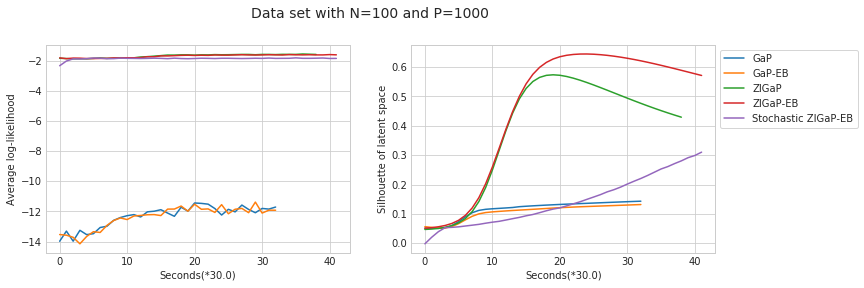

In [11]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(infgap.ll_time, label='GaP')
ax.plot(infgapeb.ll_time, label='GaP-EB')
ax.plot(infzigap.ll_time, label='ZIGaP')
ax.plot(infzigapeb.ll_time, label='ZIGaP-EB')
ax.plot(infzigapebsvi.ll_time, label='Stochastic ZIGaP-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
ax.plot(infgap.silh_time, label='GaP')
ax.plot(infgapeb.silh_time, label='GaP-EB')
ax.plot(infzigap.silh_time, label='ZIGaP')
ax.plot(infzigapeb.silh_time, label='ZIGaP-EB')
ax.plot(infzigapebsvi.silh_time, label='Stochastic ZIGaP-EB')
plt.ylabel('Silhouette of latent space')
plt.xlabel('Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Data set with N={} and P={}'.format(N, P), fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [12]:
gap_dll = utils.log_likelihood(Y_train, gap_U, gap_V, infgap.p_D, gap_S)
gapeb_dll = utils.log_likelihood(Y_train, gapeb_U, gapeb_V, infgapeb.p_D, gapeb_S)
zigap_dll = utils.log_likelihood(Y_train, zigap_U, zigap_V, infzigap.p_D, zigap_S)
zigapeb_dll = utils.log_likelihood(Y_train, zigapeb_U, zigapeb_V, infzigapeb.p_D, zigapeb_S)

scores = {'GaP': gap_dll, 'GaP-EB': gapeb_dll, 'ZIGaP': zigap_dll, 'ZIGaP-EB': zigapeb_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Full data log-likelihood:
- ZIGaP: -1.57
- ZIGaP-EB: -1.61
- GaP: -11.8
- GaP-EB: -11.8


In [13]:
gap_holl = infgap.predictive_ll(Y_test)
gapeb_holl = infgapeb.predictive_ll(Y_test)
zigap_holl = infzigap.predictive_ll(Y_test)
zigapeb_holl = infzigapeb.predictive_ll(Y_test)

scores = {'GaP': gap_holl, 'GaP-EB': gapeb_holl, 'ZIGaP': zigap_holl, 'ZIGaP-EB': zigapeb_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Held-out log-likelihood:
- ZIGaP: -1.72
- ZIGaP-EB: -1.78
- GaP-EB: -14.6
- GaP: -14.6


In [14]:
true_silh = silhouette_score(U_train, c_train)
gap_silh = silhouette_score(gap_U, c_train)
gapeb_silh = silhouette_score(gapeb_U, c_train)
zigap_silh = silhouette_score(zigap_U, c_train)
zigapeb_silh = silhouette_score(zigapeb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'GaP': gap_silh, 'GaP-EB': gapeb_silh, 'ZIGaP': zigap_silh, 'ZIGaP-EB': zigapeb_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- ZIGaP-EB: 0.571
- ZIGaP: 0.429
- GaP: 0.144
- GaP-EB: 0.132
- PCA: 0.0189

Silhouette of true U:
0.560


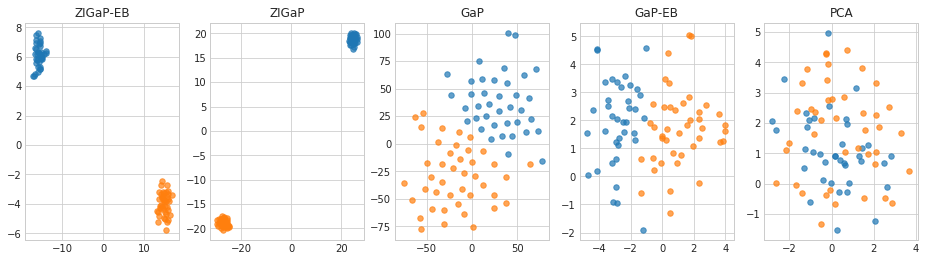

In [15]:
# Plot in decreasing silhouette order
U_list = [gap_tsne, gapeb_tsne, zigap_tsne, zigapeb_tsne, pca_tsne]
title_list = ['GaP', 'GaP-EB', 'ZIGaP', 'ZIGaP-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()

# Dropout identification and imputation
The held-out likelihood is only useful for data which isn't dominated by zeros. When it is, higher likelihoods will be obtained by models which place more mass at zero, which is not the comparison we want to make. In this case then, we evaluate the ability of the model to impute dropped out values.

We know what entries are dropouts because we have simulated them, and we also know the true value behind it.

First, we check if the model has identified dropouts well.

Then, we replace each dropout with the value the model finds to be most likely and compare it with the true value. For pCMF, imputing the entry $Y_{ij}$ corresponds to setting it to $U_iV_j $.

In [16]:
dropout_idx = np.where(D_train == 0)

## Dropout identification

In [17]:
gap_prec = accuracy_score(gap_D.flatten(), D_train.flatten())
gapeb_prec = accuracy_score(gapeb_D.flatten(), D_train.flatten())
zigap_prec = accuracy_score(zigap_D.flatten(), D_train.flatten())
zigapeb_prec = accuracy_score(zigapeb_D.flatten(), D_train.flatten())

scores = {'GaP': gap_prec, 'GaP-EB': gapeb_prec, 'ZIGaP': zigap_prec, 'ZIGaP-EB': zigapeb_prec}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Dropout identification accuracy (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Dropout identification accuracy (higher is better):
- GaP: 0.496
- GaP-EB: 0.496
- ZIGaP: 0.496
- ZIGaP-EB: 0.496


## Dropout imputation 

In [18]:
# Use the posterior Poisson mean
gap_R = np.dot(gap_U, gap_V.T)
gapeb_R = np.dot(gapeb_U, gapeb_V.T)
zigap_R = np.dot(zigap_U, zigap_V.T)
zigapeb_R = np.dot(zigapeb_U, zigapeb_V.T)

In [19]:
# Compute the imputation error on the data entries we know to be dropouts
gap_err = utils.imputation_error(X_train, gap_R, dropout_idx)
gapeb_err = utils.imputation_error(X_train, gapeb_R, dropout_idx)
zigap_err = utils.imputation_error(X_train, zigap_R, dropout_idx)
zigapeb_err = utils.imputation_error(X_train, zigapeb_R, dropout_idx)

scores = {'GaP': gap_err, 'GaP-EB': gapeb_err, 'ZIGaP': zigap_err, 'ZIGaP-EB': zigapeb_err}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=False)

print('Dropout imputation error (lower is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Dropout imputation error (lower is better):
- ZIGaP-EB: 4.49
- ZIGaP: 4.5
- GaP: 18.3
- GaP-EB: 18.4


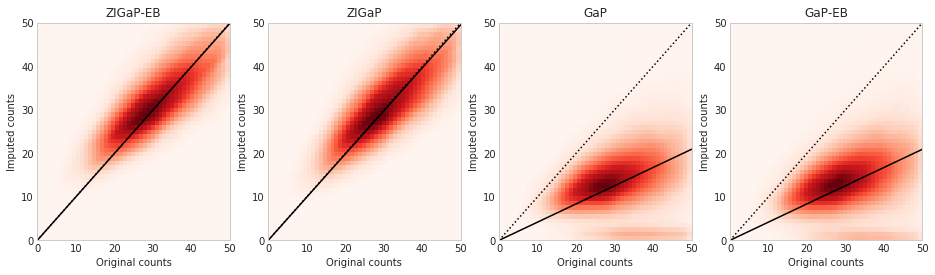

In [20]:
R_list = [gap_R, gapeb_R, zigap_R, zigapeb_R]
title_list = ['GaP', 'GaP-EB', 'ZIGaP', 'ZIGaP-EB']

fig = plt.figure(figsize=(20, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(R_list)):
    ax = plt.subplot(1, n_results, i+1)
    plot_utils.plot_imputation_density(
        R_list[title_list.index(sorted_scores[i][0])], X_train, dropout_idx, ymax=50, 
        ax=ax, title=sorted_scores[i][0])
plt.show()